In [1]:
pip install transformers torch scikit-learn datasets



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /opt/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [45]:
#Import Library
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score



## Implement BERT model

This fine-tunes a pre-trained BERT model to classify text data into four severity levels: Less Severe, Moderate Severe, Severe, and Most Severe. It tokenizes the text using the BERT tokenizer, maps labels to numerical values, and creates PyTorch datasets for training and validation. The model is trained using the Trainer class with evaluation performed at each epoch to compute accuracy and F1-score. After training, the fine-tuned model and tokenizer are saved for future use, providing an effective tool for severity classification in text data.

In [47]:

# Load the data
labeled_data = pd.read_csv('labeled_severity_data.csv')

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    labeled_data['FOI_TEXT'],  # Text data
    labeled_data['Severity_Label'],  # Labels
    test_size=0.1  # You can adjust the test size
)

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)

# Convert labels to numerical values
label_mapping = {'Less Severe': 0, 'Moderate Severe': 1, 'Severe': 2, 'Most Severe': 3}
train_labels = train_labels.map(label_mapping)
val_labels = val_labels.map(label_mapping)

# Create a PyTorch dataset
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create PyTorch datasets
train_dataset = TextDataset(train_encodings, train_labels.tolist())
val_dataset = TextDataset(val_encodings, val_labels.tolist())

# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",  # Fix the deprecation warning by using eval_strategy
    per_device_train_batch_size=4,  # Batch size
    per_device_eval_batch_size=2,  # Evaluation batch size
    num_train_epochs=2,  # Number of epochs
    weight_decay=0.01,
    logging_dir='./logs',
    use_cpu=True  # Use CPU
)

# Define evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {"accuracy": acc, "f1": f1}

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Validation results: {eval_results}")

# Save the fine-tuned model and tokenizer
model.save_pretrained('./fine_tuned_model')
tokenizer.save_pretrained('./fine_tuned_model')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.255412,0.949772,0.949573
2,0.608400,0.218237,0.968037,0.968008


Validation results: {'eval_loss': 0.21823659539222717, 'eval_accuracy': 0.9680365296803652, 'eval_f1': 0.9680083148093397, 'eval_runtime': 30.0272, 'eval_samples_per_second': 7.293, 'eval_steps_per_second': 3.663, 'epoch': 2.0}


('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/vocab.txt',
 './fine_tuned_model/added_tokens.json')

In [51]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd

# Load your new dataset
new_data = pd.read_csv('labeled_severity_data.csv') 
# Load the fine-tuned model and tokenizer
model = BertForSequenceClassification.from_pretrained('./fine_tuned_model')
tokenizer = BertTokenizer.from_pretrained('./fine_tuned_model')

# Ensure model is in evaluation mode
model.eval()

# Set up batch processing
batch_size = 3  
texts = new_data['FOI_TEXT'].tolist()  
predictions = []

# Process the texts in batches
for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i+batch_size]
    
    # Tokenize the batch of texts
    inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
    
    # Run the model to get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        batch_predictions = torch.argmax(outputs.logits, dim=1)
    
    # Append the predictions
    predictions.extend(batch_predictions.tolist())

# Map numerical predictions back to labels
label_mapping = {0: 'Less Severe', 1: 'Moderate Severe', 2: 'Severe', 3: 'Most Severe'}
predicted_labels = [label_mapping[pred] for pred in predictions]

# Add predictions to the original dataframe
new_data['Predicted_Severity'] = predicted_labels

# Save the predictions to a new CSV file
new_data.to_csv('predicted_severity_results.csv', index=False)

# Show the first few rows with predictions
print(new_data.head())


   MDR_REPORT_KEY  DEVICE_SEQUENCE_NO DATE_RECEIVED  \
0        16526816                 1.0    2023/03/10   
1        14140482                 1.0    2022/04/19   
2        14375689                 1.0    2022/05/12   
3        12747233                 1.0    2021/11/03   
4        13361371                 1.0    2022/01/26   

                           BRAND_NAME                           GENERIC_NAME  \
0                           ACCENT DR  IMPLANTABLE PACEMAKER PULSE GENERATOR   
1  CAPSUREFIX NOVUS LEAD MRI SURESCAN          PERMANENT PACEMAKER ELECTRODE   
2                        ASSURITY MRI  IMPLANTABLE PACEMAKER PULSE GENERATOR   
3                         TENDRIL STS          PERMANENT PACEMAKER ELECTRODE   
4                        ASSURITY MRI  IMPLANTABLE PACEMAKER PULSE GENERATOR   

                  MANUFACTURER_D_NAME MANUFACTURER_D_ADDRESS_1  \
0  ST. JUDE MEDICAL, INC.(CRM-SYLMAR)  15900 VALLEY VIEW COURT   
1                                MPRI         ROAD 149 K

## Distribution of severity levels

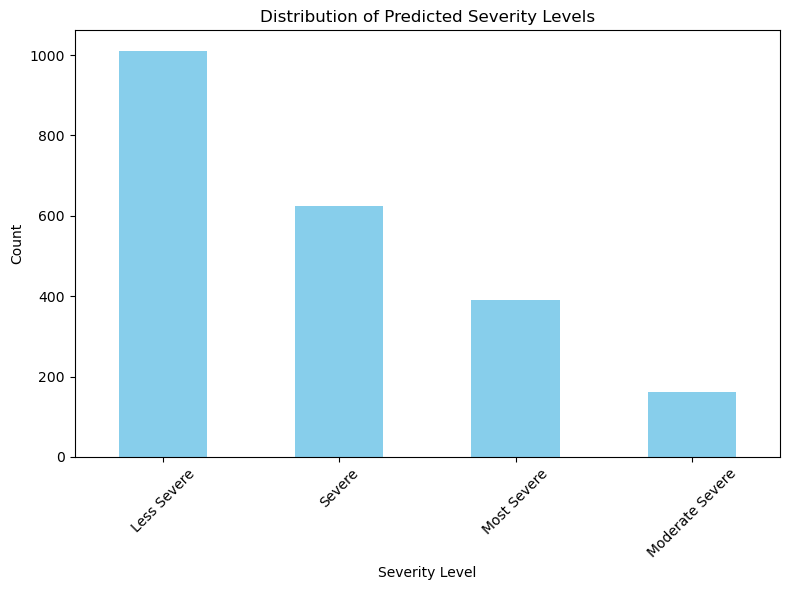

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset with predictions
new_data = pd.read_csv('predicted_severity_results.csv') 

# Analyze the distribution of predicted severity levels
severity_counts = new_data['Predicted_Severity'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
severity_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Predicted Severity Levels')
plt.xlabel('Severity Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Performance Metrics

This generates a detailed classification report to evaluate the performance of the severity classification model. It compares the true severity labels (Severity_Label) with the predicted labels (Predicted_Severity) and produces metrics such as precision, recall, F1-score, and support for each class. The report is converted into a DataFrame for a clear and tabular representation, providing valuable insights into the model's accuracy and effectiveness across all severity categories.

In [57]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate the classification report
report = classification_report(new_data['Severity_Label'], new_data['Predicted_Severity'], output_dict=True)

# Convert the classification report into a DataFrame for a tabular display
report_df = pd.DataFrame(report).transpose()

report_df.style.set_caption("Classification Report")


,precision,recall,f1-score,support
Less Severe,0.968348,0.988889,0.978511,990.000000
Moderate Severe,0.956522,0.950617,0.953560,162.000000
Most Severe,0.971795,0.984416,0.978065,385.000000
Severe,0.979167,0.941448,0.959937,649.000000
accuracy,0.971180,0.971180,0.971180,0.971180
macro avg,0.968958,0.966343,0.967518,2186.000000
weighted avg,0.971291,0.971180,0.971069,2186.000000


## ROC Curve Analysis for Severity Classification

This evaluates the performance of a multi-class severity classification model using Receiver Operating Characteristic (ROC) curves. It leverages a pipeline of TF-IDF vectorization and logistic regression to classify text data into four severity levels. The true and predicted probabilities are used to calculate the False Positive Rate (FPR), True Positive Rate (TPR), and Area Under the Curve (AUC) for each severity level. The ROC curves for all classes are plotted, providing a visual representation of the model's discriminatory power and performance across different severity levels.

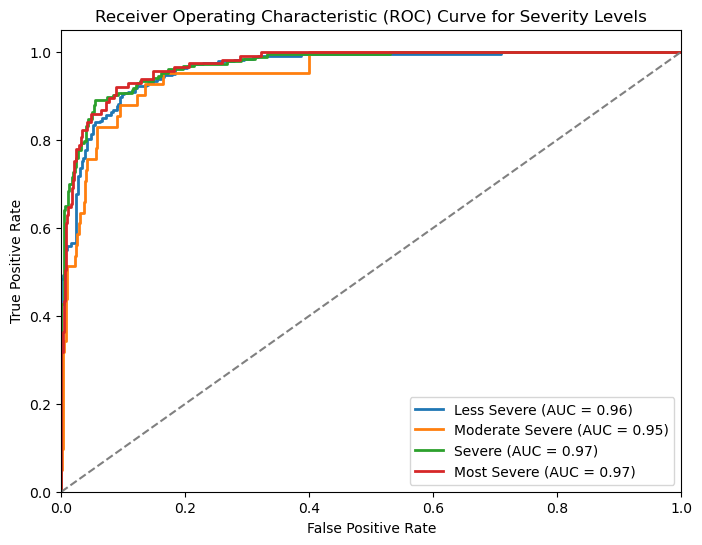

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsRestClassifier

# Load your dataset
new_data = pd.read_csv('labeled_severity_data.csv')

# Encode severity labels numerically
label_mapping = {'Less Severe': 0, 'Moderate Severe': 1, 'Severe': 2, 'Most Severe': 3}
new_data['Severity_Label'] = new_data['Severity_Label'].map(label_mapping)

# Define features and labels
X = new_data['FOI_TEXT']  # Text data
y = new_data['Severity_Label']  # Severity labels

# Binarize labels for multi-class ROC
y_bin = label_binarize(y, classes=[0, 1, 2, 3])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Use TF-IDF vectorizer with Logistic Regression for classification
model = make_pipeline(TfidfVectorizer(), OneVsRestClassifier(LogisticRegression(max_iter=1000)))
model.fit(X_train, y_train)

# Get predicted probabilities
y_score = model.predict_proba(X_test)

# Initialize dictionaries for FPR, TPR, and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_bin.shape[1]

# Binarize the test labels for ROC curve calculation
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    class_name = list(label_mapping.keys())[i]
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Severity Levels')
plt.legend(loc="lower right")
plt.show()

## Predicting severity levels

<Figure size 1200x800 with 0 Axes>

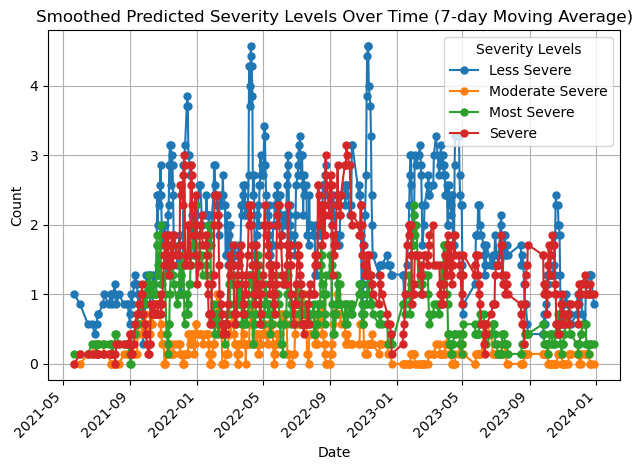

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset with predictions
new_data = pd.read_csv('predicted_severity_results.csv')  

# Convert the date column to datetime format
new_data['DATE_RECEIVED'] = pd.to_datetime(new_data['DATE_RECEIVED'])

# Group by date and calculate the count of each severity level over time
severity_trends = new_data.groupby(['DATE_RECEIVED', 'Predicted_Severity']).size().unstack().fillna(0)

# Apply a 7-day moving average to smooth the trends
severity_trends_smooth = severity_trends.rolling(window=7).mean()

# Plot the smoothed trends with reduced marker size and larger figure
plt.figure(figsize=(12, 8))
severity_trends_smooth.plot(kind='line', marker='o', markersize=5)
plt.title('Smoothed Predicted Severity Levels Over Time (7-day Moving Average)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Severity Levels')
plt.tight_layout()
plt.grid(True)
plt.show()


In [7]:
pip install prophet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 3.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.5 MB/s eta 0:00:0000:01:00:01

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /opt/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


09:11:08 - cmdstanpy - INFO - Chain [1] start processing
09:11:08 - cmdstanpy - INFO - Chain [1] done processing


NameError: name 'fig' is not defined

<Figure size 700x600 with 0 Axes>

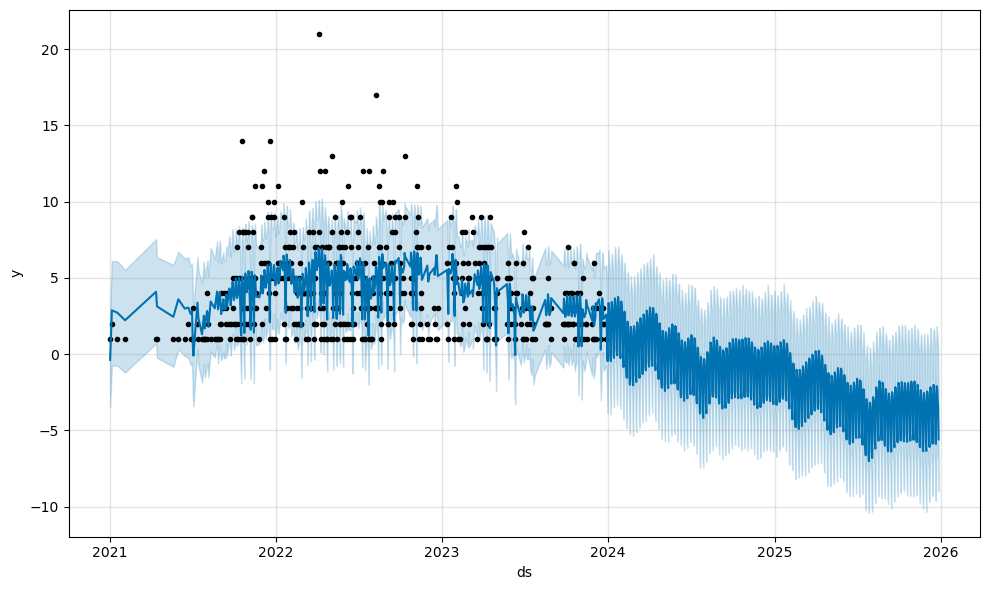

In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load the dataset with predictions
new_data = pd.read_csv('predicted_severity_results.csv')  
# Convert the date column to datetime format
new_data['DATE_RECEIVED'] = pd.to_datetime(new_data['DATE_RECEIVED'])

# Aggregate data by date for forecasting severity levels
severity_trends = new_data.groupby('DATE_RECEIVED').size().reset_index(name='count')

# Prepare the data for Prophet (rename columns as required by Prophet: 'ds' for date, 'y' for value)
severity_trends = severity_trends.rename(columns={'DATE_RECEIVED': 'ds', 'count': 'y'})

# Initialize and fit the Prophet model
model = Prophet()
model.fit(severity_trends)

# Create a future dataframe for the next 2 years (until 2026)
future = model.make_future_dataframe(periods=730)  # 730 days = approx. 2 years

# Predict the future severity trends
forecast = model.predict(future)

# Plot the forecast
plt.figure(figsize=(7, 6))
model.plot(forecast)
ax = fig.gca()  # Get the current axes

ax.set_ylim(bottom=0)  # Set the y-axis to start at 0

plt.title('Future Trend Prediction of Severity Levels Over the Next Two Years (until 2026)')
plt.xlabel('Date')
plt.ylabel('Predicted Severity Count')
plt.show()

# Optional: plot forecast components (trend, seasonality)
plt.figure(figsize=(7, 6))
model.plot_components(forecast)
plt.show()


09:16:42 - cmdstanpy - INFO - Chain [1] start processing
09:16:42 - cmdstanpy - INFO - Chain [1] done processing
09:16:42 - cmdstanpy - INFO - Chain [1] start processing
09:16:42 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 700x600 with 0 Axes>

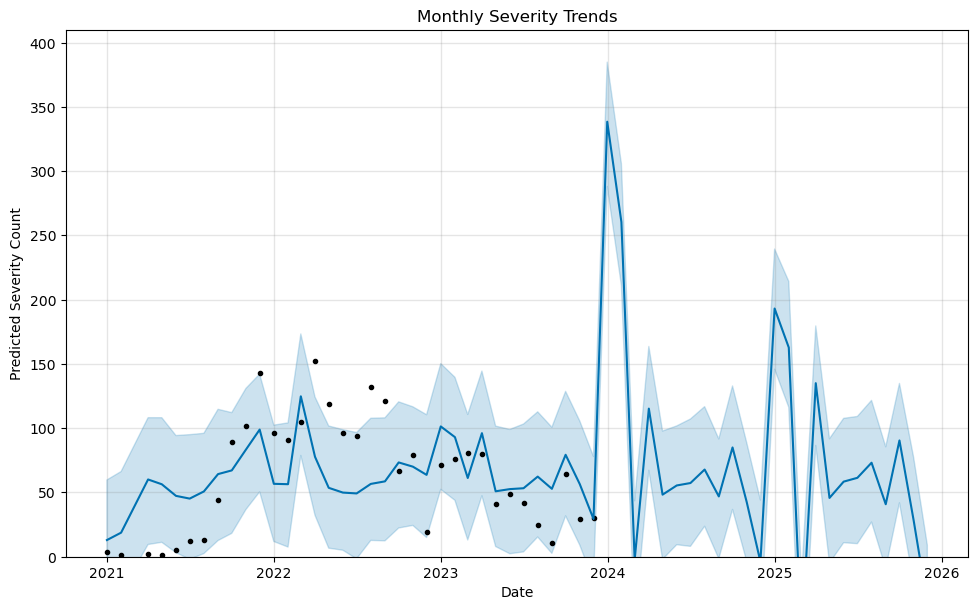

In [11]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load the dataset with predictions
new_data = pd.read_csv('predicted_severity_results.csv') 

# Convert the date column to datetime format
new_data['DATE_RECEIVED'] = pd.to_datetime(new_data['DATE_RECEIVED'])

# Aggregate data by date for forecasting severity levels (yearly)
severity_trends_yearly = new_data.groupby('DATE_RECEIVED').size().reset_index(name='count')

# Prepare the data for Prophet (rename columns as required by Prophet: 'ds' for date, 'y' for value)
severity_trends_yearly = severity_trends_yearly.rename(columns={'DATE_RECEIVED': 'ds', 'count': 'y'})

# Initialize and fit the Prophet model for yearly trends
model_yearly = Prophet()
model_yearly.fit(severity_trends_yearly)



# --- Monthly Trends ---
# Aggregate data by month
new_data['MONTH_RECEIVED'] = new_data['DATE_RECEIVED'].dt.to_period('M').dt.start_time
severity_trends_monthly = new_data.groupby('MONTH_RECEIVED').size().reset_index(name='count')
severity_trends_monthly = severity_trends_monthly.rename(columns={'MONTH_RECEIVED': 'ds', 'count': 'y'})

# Fit and forecast monthly trends
model_monthly = Prophet()
model_monthly.fit(severity_trends_monthly)
future_monthly = model_monthly.make_future_dataframe(periods=24, freq='M')  # 24 months into the future
forecast_monthly = model_monthly.predict(future_monthly)

# Plot monthly trends
plt.figure(figsize=(7, 6))
fig_monthly = model_monthly.plot(forecast_monthly)
ax_monthly = fig_monthly.gca()
ax_monthly.set_ylim(bottom=0)  # Ensure y-axis starts at 0
plt.title('Monthly Severity Trends')
plt.xlabel('Date')
plt.ylabel('Predicted Severity Count')
plt.show()




## Future Trend analysis Using ARIMA model

This analyzes and forecasts future trends for the top 20 adverse events extracted from text data. It identifies adverse events based on predefined keywords, groups the data by quarter, and applies the ARIMA model to predict future occurrences. The top 20 adverse events are split into two groups, and their observed and forecasted trends are visualized separately. The forecast spans the next four quarters, providing valuable insights into potential future trends in adverse event reporting to support proactive decision-making.









/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


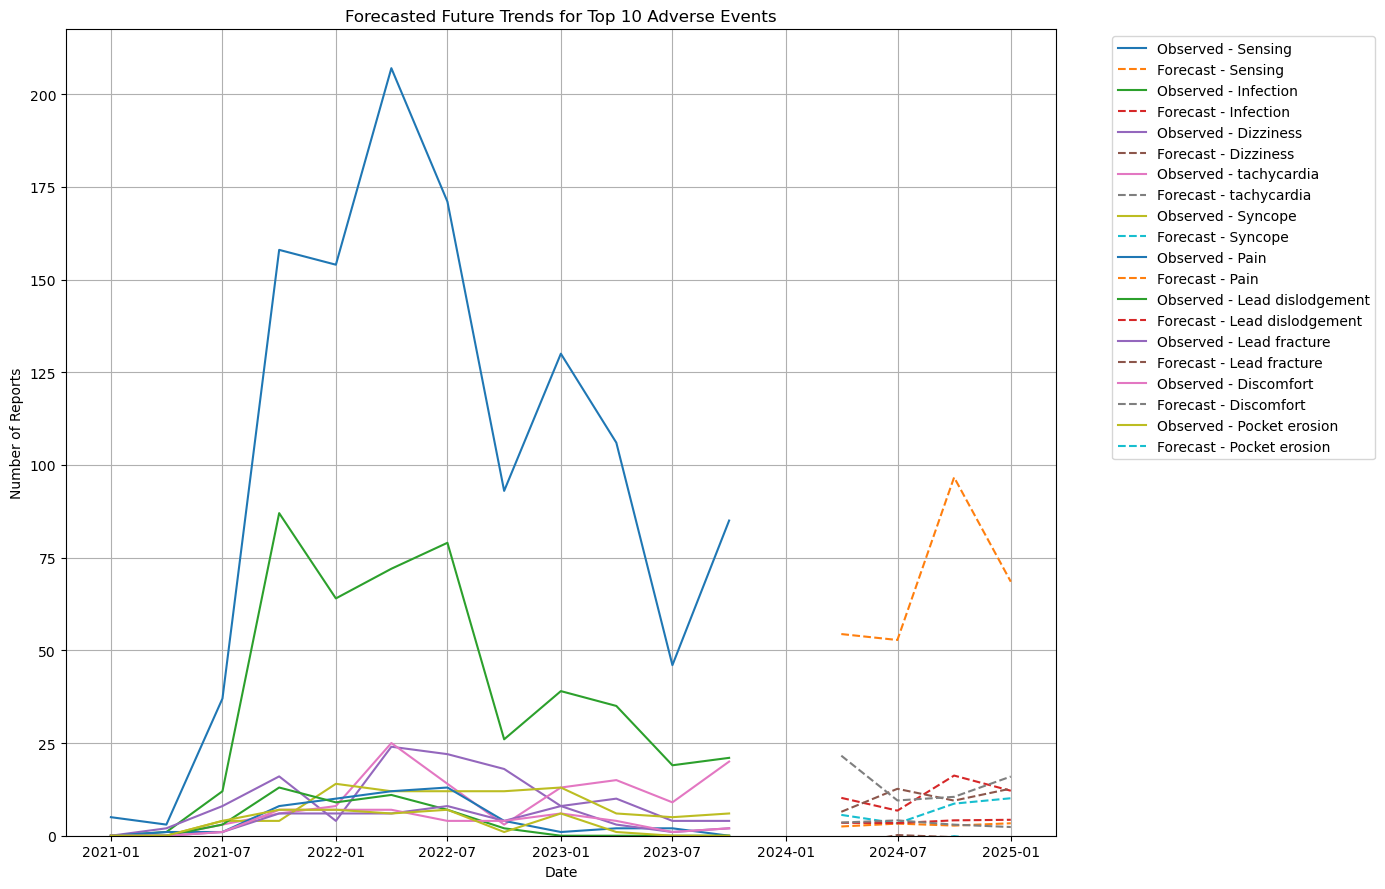

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive para

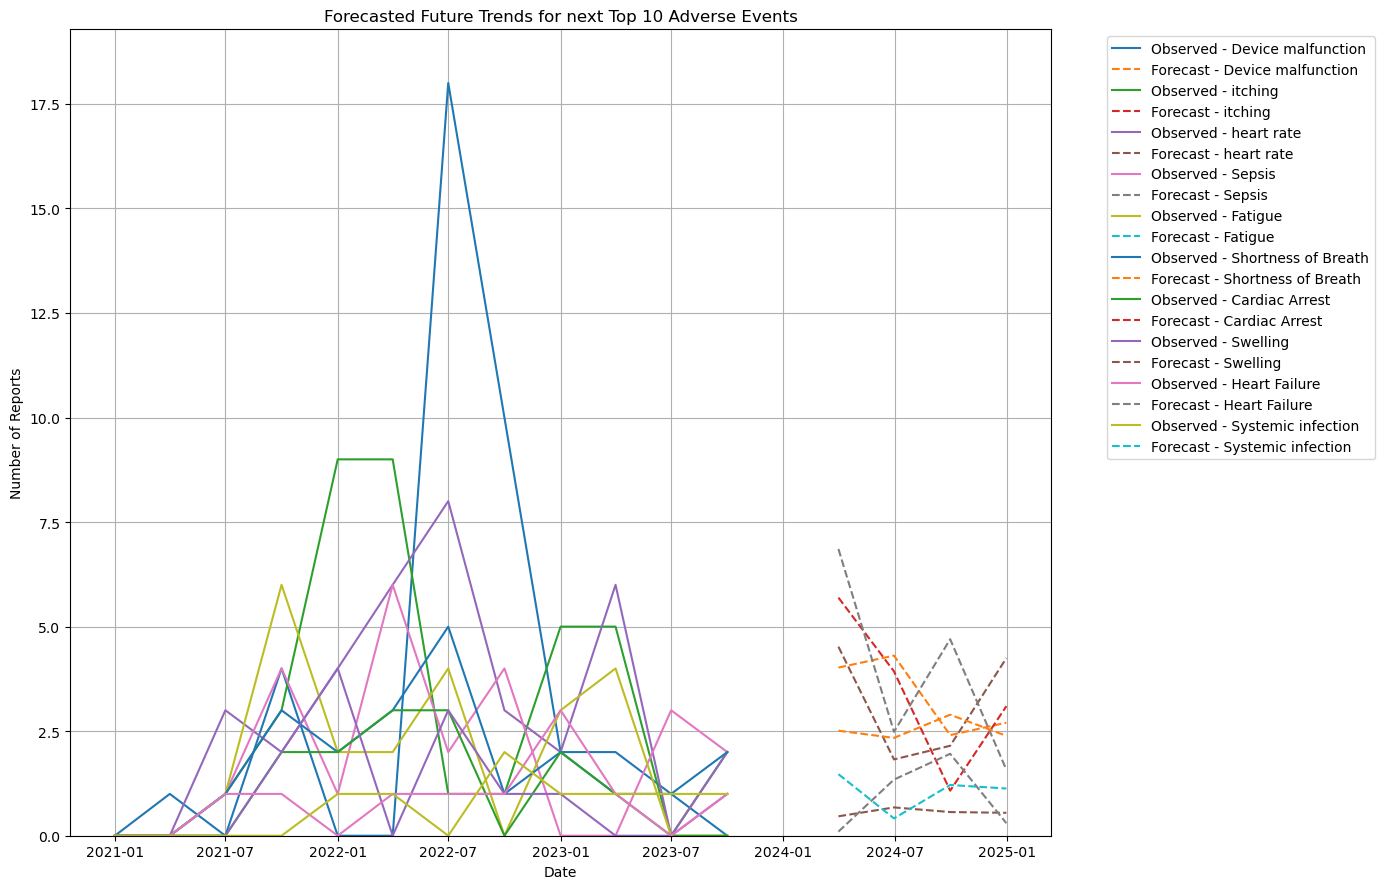

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

df_latest = pd.read_csv('finaldata.csv')  

# Convert DATE_RECEIVED to datetime
df_latest['DATE_RECEIVED'] = pd.to_datetime(df_latest['DATE_RECEIVED'], errors='coerce')

# Define adverse event keywords
updated_adverse_event_keywords = [
    'Pain', 'bowel problem', 'Device Problem', 'Dizziness', 'Shortness of Breath', 'implant failure',
    'sexual problem', 'dyspareunia', 'chronic inflammation',
    'incontinence', 'recurrence','prolapse recurrence','tachycardia','Sensing',
    'Infection', 'Dyspareunia', 'Urinary problem','Chronic Inflammation','heart rate','Urinary problem',
    'Mental Stress', 'Chronic Inflammation', 'Incontinence recurrence', 'Nausea', 'Prolapse Recurrence',
    'Swelling',  'Bleeding', 'Discomfort', 'Sleeping Issue', 'Constipation', 'Diarrhea',
    'Allergic reaction', 'Lead dislodgement', 'Infection at the implantation site', 'Pocket erosion',
    'Lead fracture', 'Myocardial perforation', 'Arrhythmias', 'Device malfunction', 'Dyspareunia',
    'Twiddler’s syndrome', 'itching', 'Dizziness', 'Syncope', 'Migration', 'Arthritis',
    'Fatigue', 'Arm pain', 'Shoulder pain', 'Device migration', 'Device recall', 
    'Systemic infection', 'Erosion of the pacemaker pocket',  'Sepsis','Anemia', 'Arthritis', 'Cardiac Arrest',  'Heart Failure'
]

# Function to find adverse events in the text
def find_adverse_events(text):
    found_events = []
    for keyword in updated_adverse_event_keywords:
        if keyword.lower() in text.lower():
            found_events.append(keyword)
    return found_events

# Apply the function to find adverse events
df_latest['ADVERSE_EVENTS'] = df_latest['FOI_TEXT'].apply(find_adverse_events)

# Explode the 'ADVERSE_EVENTS' list to separate rows for each event
df_events = df_latest.explode('ADVERSE_EVENTS')

# Select the top 20 adverse events
top_20_adverse_events = df_events['ADVERSE_EVENTS'].value_counts().head(20).index

# Filter the dataframe to include only the top 20 adverse events
df_top_20 = df_events[df_events['ADVERSE_EVENTS'].isin(top_20_adverse_events)]

# Group by quarter and adverse event, then count the number of reports
reports_over_time = df_top_20.groupby([df_top_20['DATE_RECEIVED'].dt.to_period('Q'), 'ADVERSE_EVENTS']).size().unstack(fill_value=0)

# Convert period to datetime
reports_over_time.index = reports_over_time.index.to_timestamp()

# Split the top 20 adverse events into two groups of 10
group_1 = top_20_adverse_events[:10]
group_2 = top_20_adverse_events[10:]

# Plot the first group of 10 adverse events
plt.figure(figsize=(14, 9))
for event in group_1:
    ts_data = reports_over_time[event]
    
    # Fit the ARIMA model
    model = ARIMA(ts_data, order=(5, 1, 0))
    model_fit = model.fit()
    
    # Forecast the future
    forecast = model_fit.forecast(steps=4)  # Forecasting for the next 4 quarters
    forecast_dates = pd.date_range(start=ts_data.index[-1] + pd.DateOffset(months=3), periods=4, freq='Q')
    
    # Plot the observed and forecasted data
    plt.plot(ts_data, label=f'Observed - {event}')
    plt.plot(forecast_dates, forecast, linestyle='--', label=f'Forecast - {event}')

plt.title('Forecasted Future Trends for Top 10 Adverse Events')
plt.xlabel('Date')
plt.ylabel('Number of Reports')
plt.ylim(0, None)  # Start y-axis from zero
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Repeat for the second group of 10 adverse events
plt.figure(figsize=(14, 9))
for event in group_2:
    ts_data = reports_over_time[event]
    
    # Fit the ARIMA model
    model = ARIMA(ts_data, order=(5, 1, 0))
    model_fit = model.fit()
    
    # Forecast the future
    forecast = model_fit.forecast(steps=4)  # Forecasting for the next 4 quarters
    forecast_dates = pd.date_range(start=ts_data.index[-1] + pd.DateOffset(months=3), periods=4, freq='Q')
    
    # Plot the observed and forecasted data
    plt.plot(ts_data, label=f'Observed - {event}')
    plt.plot(forecast_dates, forecast, linestyle='--', label=f'Forecast - {event}')

plt.title('Forecasted Future Trends for next Top 10 Adverse Events')
plt.xlabel('Date')
plt.ylabel('Number of Reports')
plt.ylim(0, None)  # Start y-axis from zero
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


## Future trends for each adverse events

This analyzes and forecasts monthly trends for the top 20 adverse events extracted from text data. It identifies adverse events using predefined keywords and aggregates their occurrences by month. Using the ARIMA model, the script forecasts the next 12 months of reports for each adverse event. Observed and forecasted trends are visualized on a 5x4 grid, with each subplot displaying the monthly time series for a specific event. This comprehensive visualization aids in understanding historical trends and anticipating future patterns in adverse event reporting.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


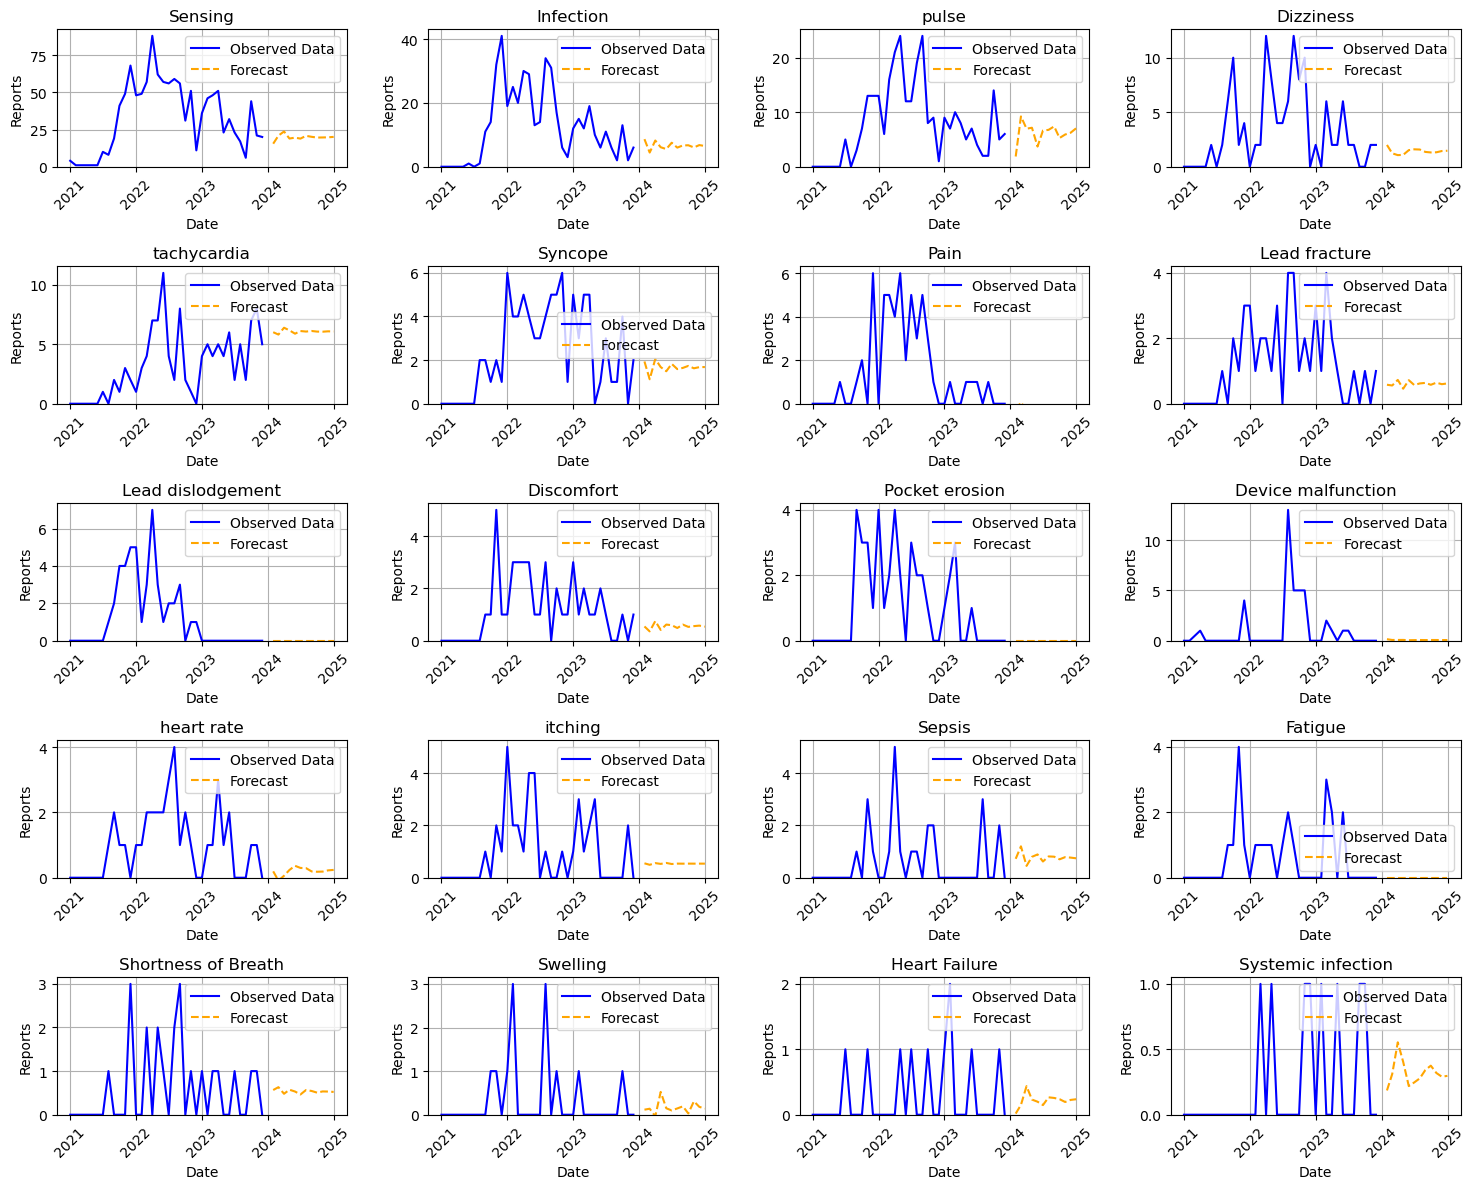

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.dates as mdates

# Convert DATE_RECEIVED to datetime
df_latest = pd.read_csv('finaldata.csv')  
df_latest['DATE_RECEIVED'] = pd.to_datetime(df_latest['DATE_RECEIVED'], errors='coerce')

# Define adverse event keywords
updated_adverse_event_keywords = [
    'Pain', 'bowel problem', 'Device Problem', 'Dizziness', 'Shortness of Breath', 'implant failure',
    'sexual problem', 'dyspareunia', 'chronic inflammation', 'pulse', 'recurrence',
    'prolapse recurrence', 'tachycardia', 'Sensing', 'Infection', 'Dyspareunia', 'Urinary problem',
    'Chronic Inflammation', 'heart rate', 'Urinary problem', 'Mental Stress', 
   'Nausea', 'Prolapse Recurrence', 'Swelling', 'Bleeding', 'Discomfort',
    'Sleeping Issue', 'Constipation', 'Diarrhea', 'Allergic reaction', 'Lead dislodgement',
    'Pocket erosion', 'Lead fracture', 
    'Arrhythmias', 'Device malfunction', 'Dyspareunia',  'itching',
    'Dizziness', 'Syncope',  'Arthritis', 'Fatigue', 
    'Device migration', 'Device recall',  'Systemic infection',
 'Sepsis',  'Arthritis', 'Heart Failure'
]

# Function to find adverse events in the text
def find_adverse_events(text):
    found_events = []
    for keyword in updated_adverse_event_keywords:
        if keyword.lower() in text.lower():
            found_events.append(keyword)
    return found_events

# Apply the function to find adverse events
df_latest['ADVERSE_EVENTS'] = df_latest['FOI_TEXT'].apply(find_adverse_events)

# Explode the 'ADVERSE_EVENTS' list to separate rows for each event
df_events = df_latest.explode('ADVERSE_EVENTS')

# Select the top 20 adverse events
top_20_adverse_events = df_events['ADVERSE_EVENTS'].value_counts().head(20).index

# Filter the dataframe to include only the top 20 adverse events
df_top_20 = df_events[df_events['ADVERSE_EVENTS'].isin(top_20_adverse_events)]

# Group by month for each adverse event
reports_over_time = df_top_20.groupby([df_top_20['DATE_RECEIVED'].dt.to_period('M'), 'ADVERSE_EVENTS']).size().unstack(fill_value=0)
reports_over_time.index = reports_over_time.index.to_timestamp()

# Create a grid for plotting
n_rows, n_cols = 5, 4  # Adjust based on the number of subplots (20 events -> 5x4 grid)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))  # Smaller figure size overall
axes = axes.flatten()  # Flatten for easy indexing

# Time Series Analysis and Forecasting for Each Adverse Event
for idx, event in enumerate(top_20_adverse_events):
    ts_data = reports_over_time[event]
    
    # Plot observed data
    axes[idx].plot(ts_data, label='Observed Data', color='blue')
    
    # Fit the ARIMA model
    model = ARIMA(ts_data, order=(5, 1, 0))
    model_fit = model.fit()
    
    # Forecast the next 12 months
    forecast = model_fit.forecast(steps=12)
    forecast_dates = pd.date_range(start=ts_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
    
    # Plot forecasted data
    axes[idx].plot(forecast_dates, forecast, linestyle='--', color='orange', label='Forecast')
    
    # Customize each subplot
    axes[idx].set_title(f'{event}')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Reports')
    axes[idx].set_ylim(0, None)
    
    # Set x-axis major ticks to yearly intervals and rotate for better readability
    axes[idx].xaxis.set_major_locator(mdates.YearLocator(1))  # Set ticks to every year
    axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as year
    axes[idx].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability
    
    axes[idx].legend()
    axes[idx].grid(True)

# Adjust layout for readability
plt.tight_layout()
plt.show()
